In [32]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Define system parameters

# Physical parameters
omega_c = 2 * np.pi * 6.826  # Cavity frequency (nu_c = 6.826 GHz)
omega_q = 2 * np.pi * 5.0258  # Qubit frequency (nu_q = 5.0258 GHz)
omega_r = 0.9 * omega_q  # Qubit drive frequency (near qubit frequency)
omega_d = 0.9 * omega_c  # Drive frequency (near cavity frequency)
chi = 2 * np.pi * -0.66 * 1e-3  # Dispersive coupling strength (chi / 2 pi = -0.66 MHz)
kappa = 2 * np.pi * 4.3 * 1e-3  # Linewidth (kappa / 2 pi = 4.3 MHz)
Omega_R = 2 * np.pi * 9 * 1e-3  # Rabi frequency (Nu_R = 9 MHz) (same as -Delta_c)

T_phi = 1  # Qubit pure dephasing time
Gamma_phi = 1 / T_phi  # Qubit pure dephasing rate
T_2 = 10.6 * 1e-6  # Qubit lab frame dephasing rate (T_2 = 10.6 μs)

# System dimensions
N_cavity = 100  # Number of Fock states for cavity
N_qubit = 2  # Number of states for qubit

# Time range
t_range = np.linspace(0, 100, 100)

# Calculate detuning
# Delta_c = omega_d - omega_c  # Cavity detuning (same as -Omega_R)
Delta_c = -Omega_R  # Cavity detuning (same as -Omega_R)

In [34]:
# Define Operators

# Identity operators
I_c = qt.qeye(N_cavity)  # Cavity identity operator
I_q = qt.qeye(N_qubit)  # Qubit identity operator

# Cavity operators
a = qt.tensor(qt.destroy(N_cavity), I_q)  # Cavity annihilation operator
n = a.dag() * a  # Cavity number operator

# Qubit operators
sigma_x = qt.tensor(I_c, qt.sigmax())  # Qubit X operator
sigma_z = qt.tensor(I_c, qt.sigmaz())  # Qubit Z operator
sigma_plus = qt.tensor(I_c, qt.create(N_qubit))  # Qubit raising operator
sigma_minus = qt.tensor(I_c, qt.destroy(N_qubit))  # Qubit lowering operator

In [35]:
# Define simulation parameters

# Master equation solver options
options = dict(
    store_states=True,
    progress_bar=True,
    nsteps=int(1e6),
    rtol=1e-4,
    atol=1e-4,
    max_step=1.0,
)

# Evaluation operators (observables)
e_ops = {
    'x': sigma_x,
    'z': sigma_z,
    'n': n,
}

# Define initial state (|0⟩_c ⊗ |+⟩_q)
psi0_cavity = qt.basis(N_cavity, 0)                                # Cavity ground state
psi0_qubit = (qt.basis(N_qubit, 0) + qt.basis(N_qubit, 1)).unit()  # Qubit |+⟩ state
psi0 = qt.tensor(psi0_cavity, psi0_qubit)

# Range of average photon numbers to simulate
blah = Delta_c + 0.5j * kappa
# displacement_range = np.sqrt(np.linspace(0, 10, 10)) * np.abs(blah) / blah
displacement_range = np.array([2]) * np.abs(blah) / blah

In [36]:
# Define functions for simulation

def hamiltonian(displacement):

    # Define displacement operator
    d = qt.tensor(qt.destroy(N_cavity) - displacement, I_q)

    # omega_q_ac = omega_q + chi * (2 * np.abs(displacement)**2)
    # omega_r = omega_q_ac
    # Delta_q = omega_q - omega_r  # Qubit detuning
    Delta_q = 0  # Qubit detuning

    # Define the Hamiltonian components
    H_cavity = -Delta_c * d.dag() * d
    H_qubit = -0.5 * (Delta_q + chi * (2 * np.abs(displacement)**2)) * sigma_z
    H_rabi = -0.5 * Omega_R * sigma_x
    H_int = -chi * (np.conj(displacement) * d + displacement * d.dag() + d.dag() * d) * sigma_z
    
    return H_cavity + H_qubit + H_rabi + H_int

def Gamma_plus(displacement):
    return 4 * chi**2 * np.abs(displacement)**2 / kappa + (1 / (2 * T_2))

def Gamma_minus(displacement):
    return kappa * chi**2 * np.abs(displacement)**2 / ((2 * Omega_R)**2 + (kappa / 2)**2) + (1 / (2 * T_2))

def P(N, i):
    return qt.tensor(qt.basis(N, i) * qt.basis(N, i).dag(), I_q)

def run_simulation(displacement):
    # Collapse operators (dissipation)
    c_ops = [
        np.sqrt(kappa) * a,
        np.sqrt(Gamma_phi / 2) * sigma_z,
        np.sqrt(Gamma_plus(displacement)) * sigma_plus,
        np.sqrt(Gamma_minus(displacement)) * sigma_minus
    ]

    H = hamiltonian(displacement)
    
    result = qt.mesolve(H, psi0, t_range, c_ops, options=options)
    
    return result


In [ ]:
# Run simulation

# Run simulations in parallel
results = qt.parallel_map(run_simulation, displacement_range)

In [30]:
# Manipulate results

# Extract states
result_states = np.array([r.states for r in results])

n_exp = np.zeros_like(result_states)

# Extract n_expect
for i, states in enumerate(result_states):
    n_exp[i] = np.array([qt.expect(a.dag() * a, state) for state in states])

print(result_states.shape)

(1, 100)


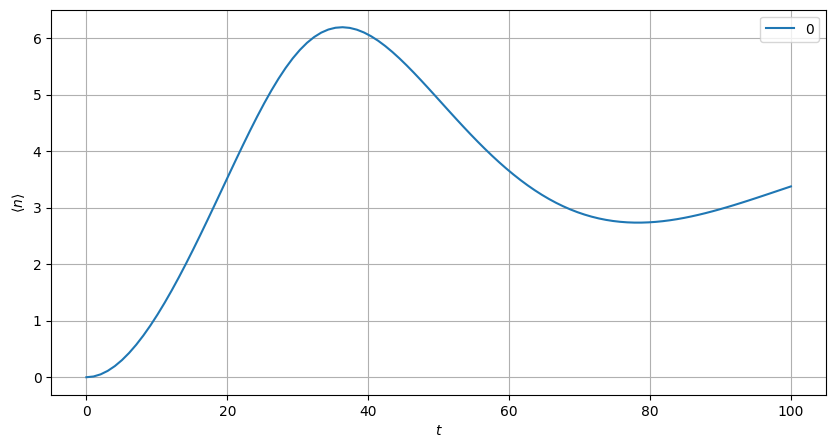

In [31]:
# Visualization

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)

for j, displacement in enumerate(displacement_range):
    
    ax1.plot(t_range, n_exp[j], label=j)


ax1.set_xlabel('$t$')
ax1.set_ylabel('$\\langle n\\rangle$')
ax1.grid(True)
ax1.legend()

plt.show()